# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial differential equation as a first model problem.
Depending on the interpretation of the unknowns and the type of measurements, this model problem arises, for instance, in electrical impedence tomography.

Let $\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_{\Omega} (u-d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= 0 \text{ in }\Omega,\\
e^m \nabla u &= j \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown parameter field, 
$u \in \mathcal{V}:= \left\{v \in H^1(\Omega) | v(\boldsymbol{x}_c) = 0 \text{ for a given point } \boldsymbol{x}_c\in \Omega \right\}$ the state variable, $d$ the (possibly noisy) data, $j\in H^{-1/2}(\partial\Omega)$ a given boundary force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the forward problem:

Find $u\in \mathcal{V}$ such that 

$$ \int_{\Omega}e^m \nabla u \cdot \nabla \tilde{p} \, dx - \int_{\partial \Omega} j \tilde{p} \,dx = 0, \text{ for all } \tilde{p}\in \mathcal{V}.$$


### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}\int_{\Omega}(u-u_d)^2 dx +
\frac{\gamma}{2}\int_\Omega \nabla m \cdot \nabla m dx +  \int_{\Omega} e^m\nabla u \cdot \nabla p dx 
- \int_{\partial \Omega} j\,p\, dx.
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ in an arbitrary direction $\tilde m$ is

$$
    (\mathcal{G}(m), \tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma \int_\Omega \nabla m \cdot \nabla \tilde{m}\, dx +
     \int_\Omega \tilde{m}e^m\nabla u \cdot \nabla p\, dx \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in \mathcal{V}$ is the solution of the forward problem,

$$ (\mathscr{L}_p(u,m,p), \tilde{p})  := \int_{\Omega}e^m\nabla u \cdot \nabla \tilde{p}\, dx - \int_{\partial\Omega} j\,\tilde{p}\, dx = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in \mathcal{V}$ is the solution of the adjoint problem,

$$ (\mathscr{L}_u(u,m,p), \tilde{u}) := \int_{\Omega} e^m\nabla p \cdot \nabla \tilde{u}\, dx + \int_{\Omega} (u-d)\tilde{u}\,dx = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method.

Written in abstract form, the steepest descent methods computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
\int_\Omega \hat{m}_k \tilde{m}\, dx = -\left(\mathcal{G}(m_k), \tilde m\right) \quad \forall \tilde{m} \in \mathcal{M},
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involve the solution $u_k$ and $p_k$ of the forward and adjoint problem (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 


### Goals:

By the end of this notebook, you should be able to:

- solve the forward and adjoint Poisson equations
- understand the inverse method framework
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Derivation of gradient via the adjoint method
- Armijo line search

### Import dependencies

In [97]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``j`` for the forward problem is

$$ j(x,y) = (x - 0.5)y(y-1) \; \forall {\boldsymbol{x}=(x,y)} \in \partial\Omega. $$

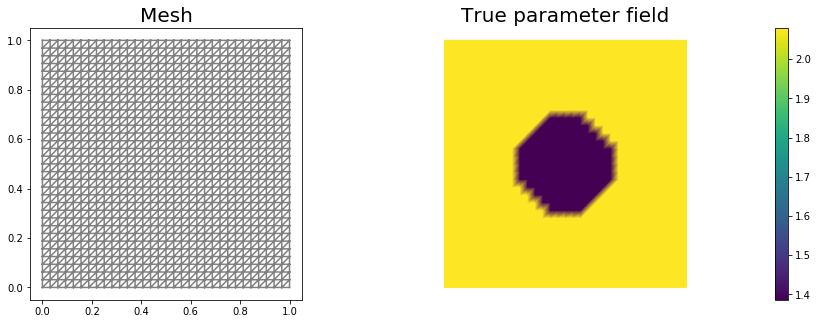

In [98]:
# create mesh and define function spaces
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
j  = dl.Expression("(x[0]-.5)*x[1]*(x[1]-1)", degree=3)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [99]:
# Fix the value of the state at the center of the domain
def d_boundary(x,on_boundary):
    return dl.near(x[0], .5) and dl.near(x[1], .5)

u0 = dl.Constant(0.)
bc_state = dl.DirichletBC(Vu, u0, d_boundary, "pointwise")
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), d_boundary, "pointwise")

### Set up synthetic observations (inverse crime):

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{\int_\Omega e^{m_{\text true}} \nabla u \cdot \nabla v \, dx}_{\; := \; a_{\rm true}} - \underbrace{\int_{\partial\Omega} j\,v\,dx}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``d`` as

$$ d = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

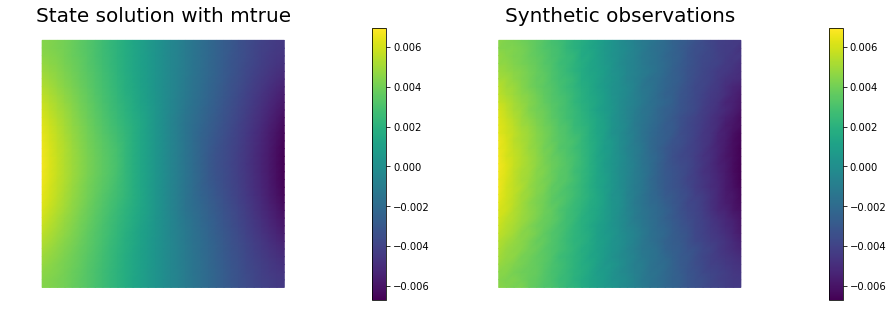

In [100]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = j * u_test * dl.ds

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

d = dl.Function(Vu)
d.assign(utrue)

# perturb state solution and create synthetic measurements d
# d = u + ||u||/SNR * random.normal
MAX = d.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(d.vector().get_local())) )
bc_adj.apply(noise)

d.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, d], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [101]:
norm_misfit = []
norm_reg = []

In [160]:
# Regularization parameter
option = [1e-8, 5e-9, 1e-9, 5e-10, 3e-10, 2e-10, 1e-10, 5e-11, 1e-11]
gamma = option[8]
beta = 0.1

# Define cost function
def cost(u, d, m, gamma):
    reg = 0.5* dl.assemble(dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + beta)*dl.dx)
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appears in the the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear form of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear form of the adjoint equation, repectively;
- `grad_misfit`, `grad_reg` stand for the contributions to the gradient coming from the data misfit and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [161]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = j * u_test * dl.ds

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - d, p_test) * dl.dx

# weak form for gradient
grad_misfit = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
#grad_reg    = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
TVm = dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + beta) 
grad_reg = gamma* dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \left(\mathcal{G}(m_0), \tilde{m}\right)\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


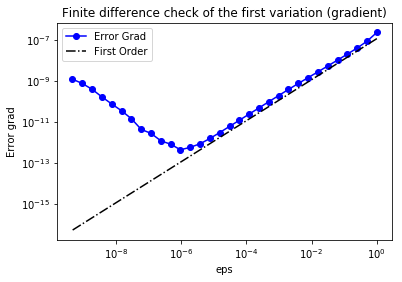

In [162]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, d, m, gamma)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(grad_misfit + grad_reg)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, d, m, gamma)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

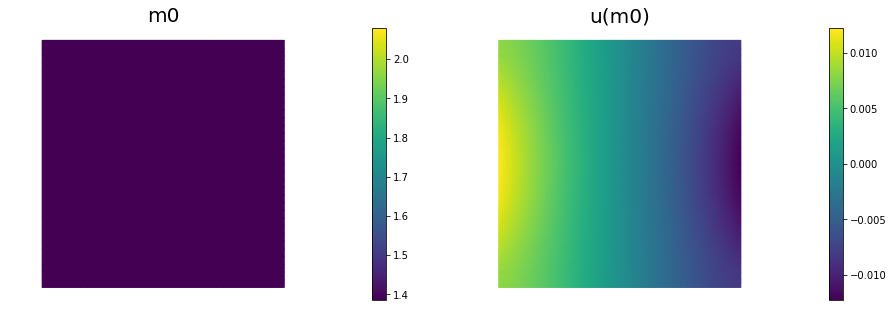

In [163]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, d, m, gamma)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equation for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   2.97420e-06   2.97418e-06   2.34912e+00   1.72104e-05   1.00000e+05     0


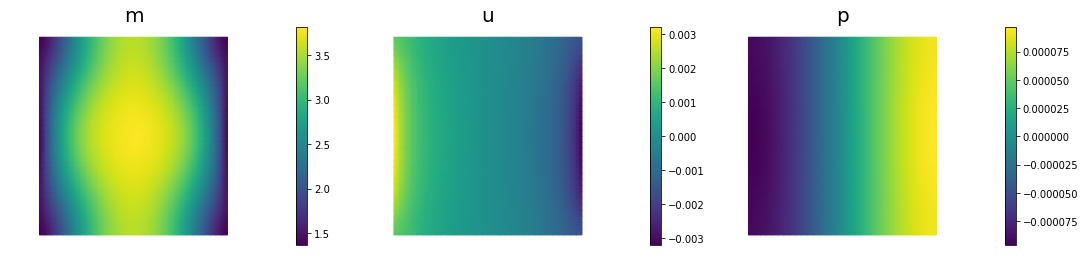

 10   2.73746e-08   2.73658e-08   8.86553e-01   3.59811e-07   1.00000e+05     0
 20   6.05222e-09   6.04162e-09   1.05924e+00   2.52462e-07   2.50000e+04     2
 30   3.93132e-09   3.92000e-09   1.13184e+00   1.61161e-07   2.50000e+04     2
 40   3.20861e-09   3.19687e-09   1.17425e+00   9.14889e-08   2.50000e+04     2
 50   2.82809e-09   2.81602e-09   1.20676e+00   3.61692e-08   5.00000e+04     1


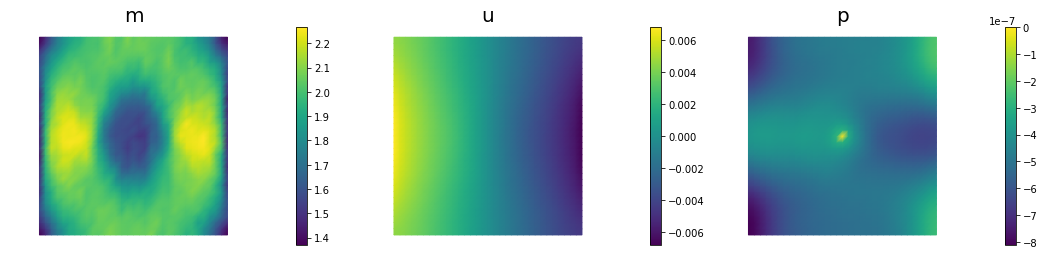

 60   2.57228e-09   2.55991e-09   1.23706e+00   4.09681e-08   5.00000e+04     1
 70   2.35197e-09   2.33932e-09   1.26465e+00   5.20303e-08   2.50000e+04     2
 80   2.17121e-09   2.15820e-09   1.30075e+00   2.54572e-08   5.00000e+04     1
 90   2.05339e-09   2.04006e-09   1.33215e+00   2.84394e-08   5.00000e+04     1
100   1.92965e-09   1.91597e-09   1.36753e+00   4.17482e-08   2.50000e+04     2


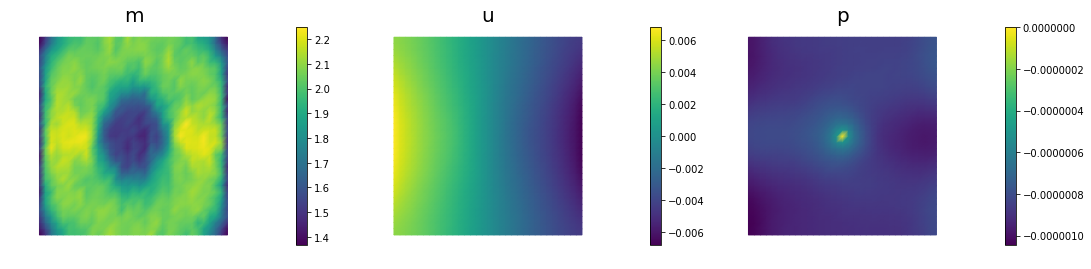

110   1.84340e-09   1.82939e-09   1.40150e+00   2.73657e-08   2.50000e+04     2
120   1.76651e-09   1.75212e-09   1.43936e+00   3.85975e-08   2.50000e+04     2
130   1.71530e-09   1.70055e-09   1.47527e+00   1.35395e-08   1.00000e+05     0
140   1.66120e-09   1.64615e-09   1.50511e+00   2.43727e-08   2.50000e+04     2
150   1.61483e-09   1.59941e-09   1.54226e+00   3.21470e-08   2.50000e+04     2


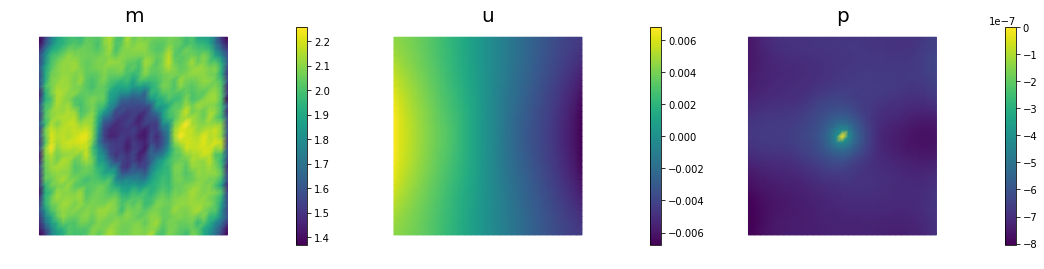

160   1.58243e-09   1.56666e-09   1.57717e+00   1.06190e-08   1.00000e+05     0
170   1.54639e-09   1.53029e-09   1.60976e+00   1.14231e-08   5.00000e+04     1
180   1.51767e-09   1.50125e-09   1.64198e+00   2.21449e-08   2.50000e+04     2
190   1.49432e-09   1.47757e-09   1.67556e+00   1.24492e-08   5.00000e+04     1
200   1.47214e-09   1.45503e-09   1.71044e+00   8.33694e-09   1.00000e+05     0


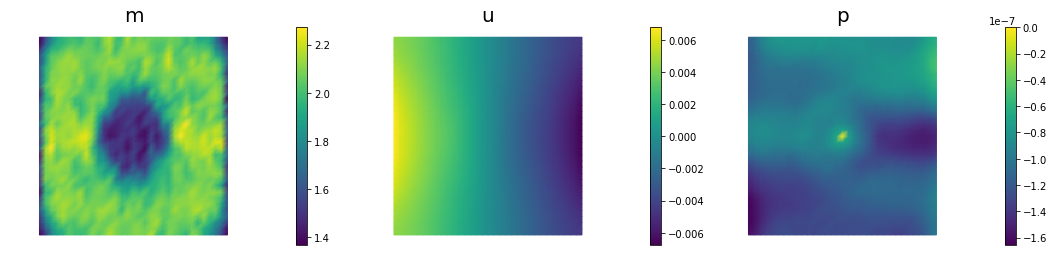

210   1.44981e-09   1.43240e-09   1.74141e+00   8.85493e-09   5.00000e+04     1
220   1.43187e-09   1.41415e-09   1.77203e+00   1.64226e-08   2.50000e+04     2
230   1.41477e-09   1.39672e-09   1.80563e+00   1.96887e-08   2.50000e+04     2
240   1.40164e-09   1.38327e-09   1.83714e+00   1.03523e-08   5.00000e+04     1
250   1.38734e-09   1.36867e-09   1.86664e+00   6.60334e-09   5.00000e+04     1


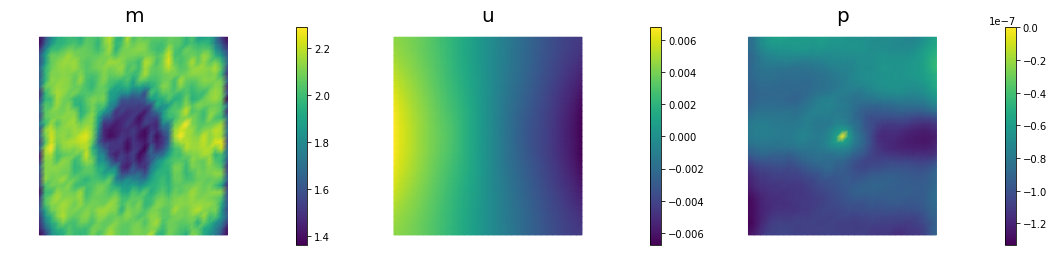

260   1.37457e-09   1.35558e-09   1.89903e+00   7.01066e-09   5.00000e+04     1
270   1.36338e-09   1.34410e-09   1.92784e+00   1.28741e-08   2.50000e+04     2
280   1.35247e-09   1.33288e-09   1.95950e+00   1.51257e-08   2.50000e+04     2
290   1.34378e-09   1.32389e-09   1.98925e+00   7.93623e-09   5.00000e+04     1
300   1.33491e-09   1.31470e-09   2.02021e+00   5.18750e-09   1.00000e+05     0


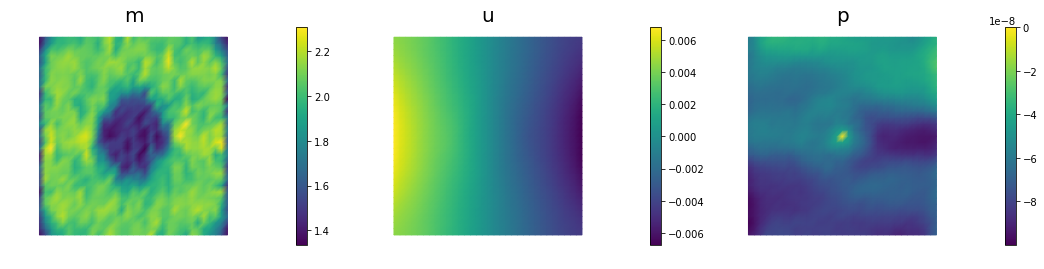

310   1.32581e-09   1.30533e-09   2.04777e+00   5.44662e-09   5.00000e+04     1
320   1.31819e-09   1.29744e-09   2.07505e+00   9.53376e-09   2.50000e+04     2
330   1.31058e-09   1.28953e-09   2.10504e+00   1.10766e-08   2.50000e+04     2
340   1.30425e-09   1.28292e-09   2.13321e+00   6.00761e-09   5.00000e+04     1
350   1.29777e-09   1.27615e-09   2.16255e+00   6.71726e-09   5.00000e+04     1


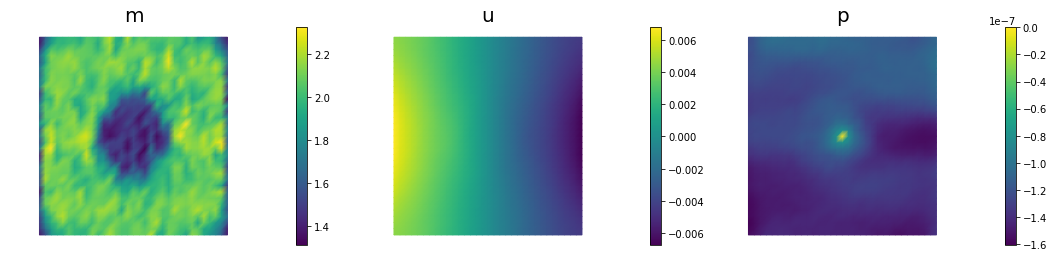

360   1.29181e-09   1.26989e-09   2.19156e+00   4.31985e-09   1.00000e+05     0
370   1.28550e-09   1.26333e-09   2.21741e+00   4.57813e-09   5.00000e+04     1
380   1.28020e-09   1.25777e-09   2.24301e+00   8.15763e-09   2.50000e+04     2
390   1.27483e-09   1.25212e-09   2.27116e+00   9.52812e-09   2.50000e+04     2
400   1.27033e-09   1.24736e-09   2.29762e+00   5.15262e-09   5.00000e+04     1


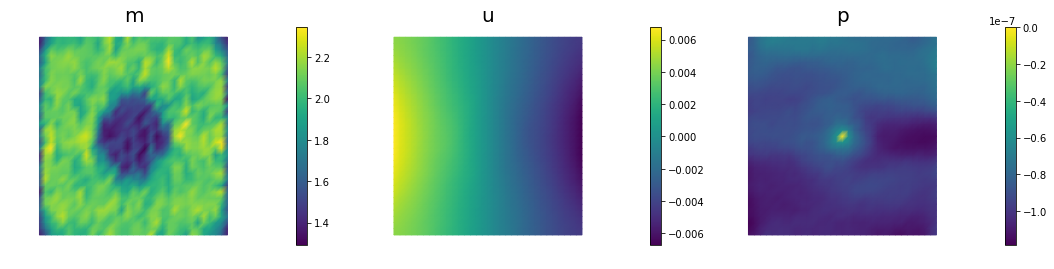

410   1.26566e-09   1.24241e-09   2.32519e+00   5.80970e-09   5.00000e+04     1
420   1.26132e-09   1.23780e-09   2.35248e+00   3.71858e-09   1.00000e+05     0
430   1.25663e-09   1.23287e-09   2.37680e+00   3.97829e-09   5.00000e+04     1
440   1.25267e-09   1.22866e-09   2.40089e+00   7.22299e-09   2.50000e+04     2
450   1.24863e-09   1.22436e-09   2.42740e+00   8.51807e-09   2.50000e+04     2


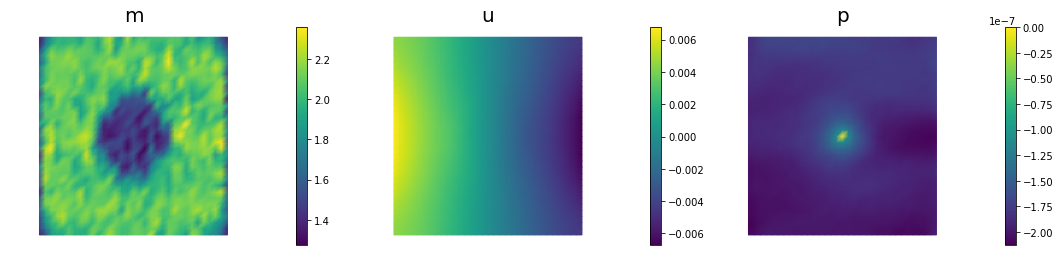

460   1.24523e-09   1.22071e-09   2.45234e+00   4.59784e-09   5.00000e+04     1
470   1.24167e-09   1.21689e-09   2.47833e+00   5.24632e-09   5.00000e+04     1
480   1.23804e-09   1.21302e-09   2.50150e+00   3.32193e-09   5.00000e+04     1
490   1.23464e-09   1.20937e-09   2.52700e+00   3.59920e-09   5.00000e+04     1
500   1.23152e-09   1.20603e-09   2.54973e+00   6.73410e-09   2.50000e+04     2


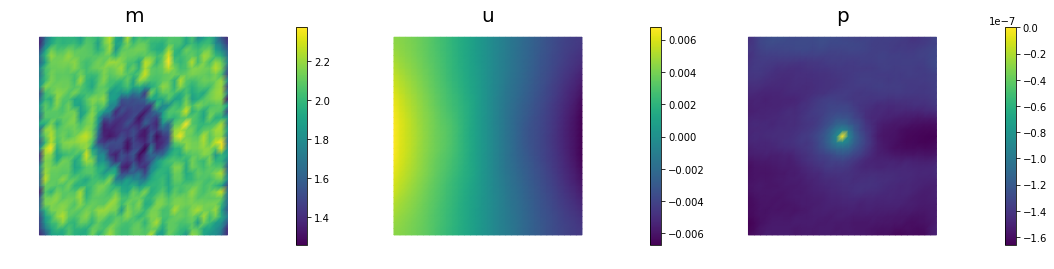

510   1.22834e-09   1.20259e-09   2.57475e+00   8.04207e-09   2.50000e+04     2
520   1.22568e-09   1.19969e-09   2.59828e+00   4.30529e-09   5.00000e+04     1
530   1.22286e-09   1.19663e-09   2.62282e+00   2.87341e-09   1.00000e+05     0
540   1.21989e-09   1.19344e-09   2.64471e+00   3.08611e-09   5.00000e+04     1
550   1.21729e-09   1.19063e-09   2.66640e+00   5.55549e-09   2.50000e+04     2


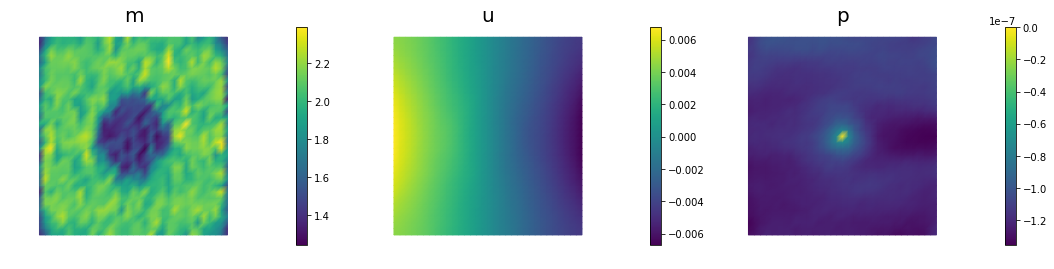

560   1.21460e-09   1.18770e-09   2.69029e+00   6.64955e-09   2.50000e+04     2
570   1.21230e-09   1.18517e-09   2.71276e+00   3.67404e-09   5.00000e+04     1
580   1.20988e-09   1.18252e-09   2.73620e+00   4.24740e-09   5.00000e+04     1
590   1.20741e-09   1.17984e-09   2.75711e+00   2.72709e-09   5.00000e+04     1
600   1.20506e-09   1.17726e-09   2.78014e+00   2.99119e-09   5.00000e+04     1


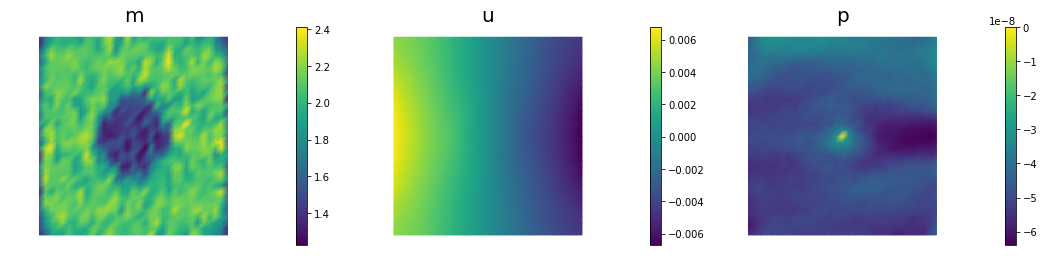

610   1.20289e-09   1.17488e-09   2.80068e+00   5.71839e-09   2.50000e+04     2
620   1.20065e-09   1.17242e-09   2.82330e+00   6.95549e-09   2.50000e+04     2
630   1.19878e-09   1.17034e-09   2.84459e+00   3.74143e-09   5.00000e+04     1
640   1.19680e-09   1.16813e-09   2.86680e+00   2.46664e-09   1.00000e+05     0
650   1.19463e-09   1.16577e-09   2.88663e+00   2.69883e-09   5.00000e+04     1


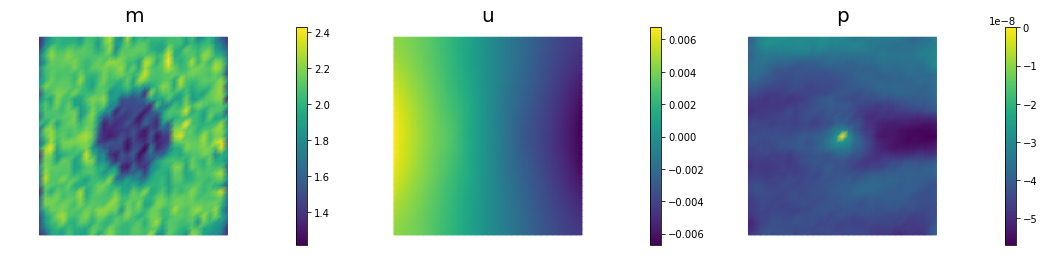

660   1.19275e-09   1.16368e-09   2.90629e+00   5.09210e-09   2.50000e+04     2
670   1.19079e-09   1.16151e-09   2.92794e+00   6.22152e-09   2.50000e+04     2
680   1.18915e-09   1.15966e-09   2.94833e+00   3.39310e-09   5.00000e+04     1
690   1.18740e-09   1.15771e-09   2.96960e+00   2.27231e-09   1.00000e+05     0
700   1.18552e-09   1.15563e-09   2.98859e+00   2.48692e-09   5.00000e+04     1


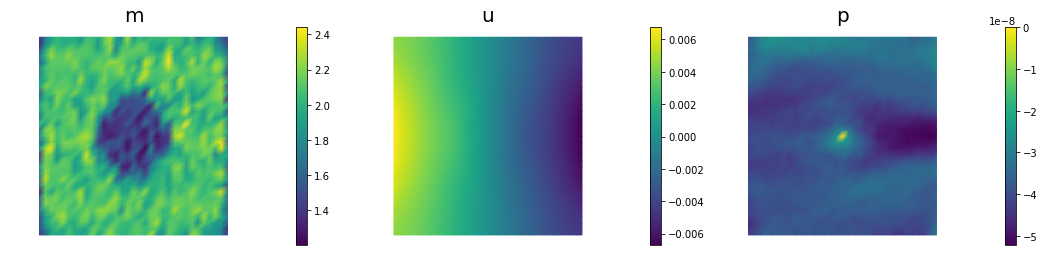

710   1.18386e-09   1.15379e-09   3.00743e+00   4.67435e-09   2.50000e+04     2
720   1.18214e-09   1.15185e-09   3.02818e+00   5.73924e-09   2.50000e+04     2
730   1.18068e-09   1.15020e-09   3.04772e+00   3.15410e-09   5.00000e+04     1
740   1.17913e-09   1.14845e-09   3.06812e+00   2.12466e-09   1.00000e+05     0
750   1.17747e-09   1.14660e-09   3.08634e+00   2.33195e-09   5.00000e+04     1


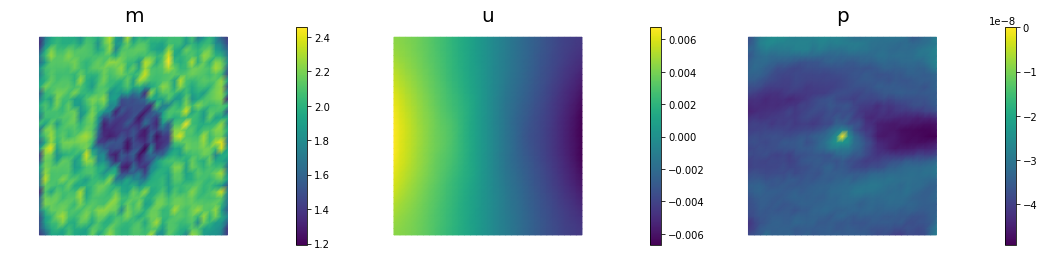

760   1.17599e-09   1.14495e-09   3.10442e+00   4.40542e-09   2.50000e+04     2
770   1.17446e-09   1.14322e-09   3.12436e+00   5.43856e-09   2.50000e+04     2
780   1.17316e-09   1.14173e-09   3.14313e+00   2.99476e-09   5.00000e+04     1
790   1.17179e-09   1.14016e-09   3.16274e+00   2.01174e-09   1.00000e+05     0
800   1.17029e-09   1.13849e-09   3.18026e+00   2.22003e-09   5.00000e+04     1


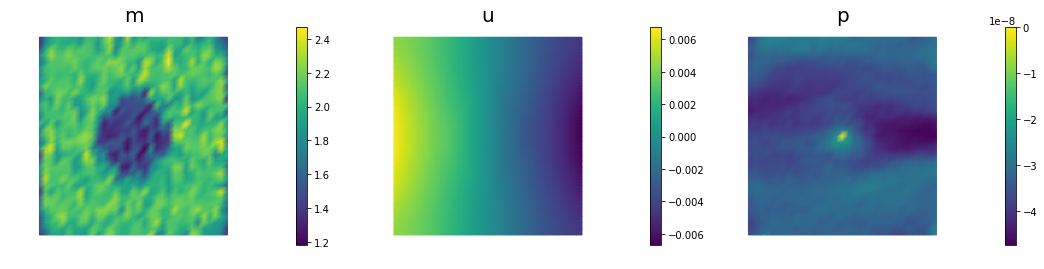

810   1.16898e-09   1.13700e-09   3.19764e+00   4.24917e-09   2.50000e+04     2
820   1.16760e-09   1.13543e-09   3.21679e+00   5.27680e-09   2.50000e+04     2
830   1.16644e-09   1.13410e-09   3.23484e+00   2.89820e-09   5.00000e+04     1
840   1.16522e-09   1.13268e-09   3.25368e+00   1.92775e-09   1.00000e+05     0
850   1.16386e-09   1.13115e-09   3.27051e+00   2.14377e-09   5.00000e+04     1


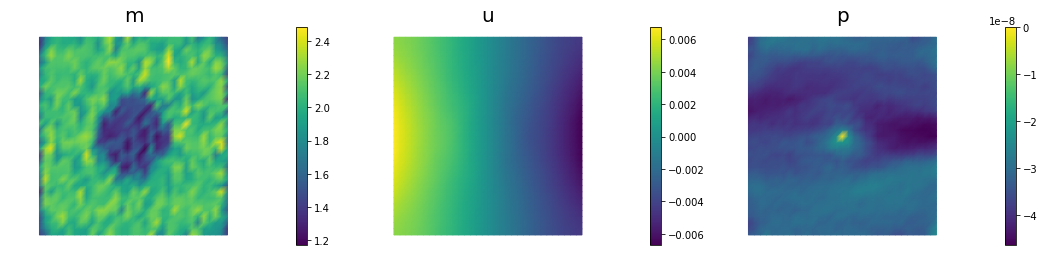

860   1.16266e-09   1.12979e-09   3.28722e+00   4.18367e-09   2.50000e+04     2
870   1.16142e-09   1.12837e-09   3.30563e+00   5.22770e-09   2.50000e+04     2
880   1.16039e-09   1.12716e-09   3.32298e+00   2.85390e-09   5.00000e+04     1
890   1.15919e-09   1.12580e-09   3.33931e+00   1.86830e-09   5.00000e+04     1
900   1.15804e-09   1.12447e-09   3.35730e+00   2.09811e-09   5.00000e+04     1


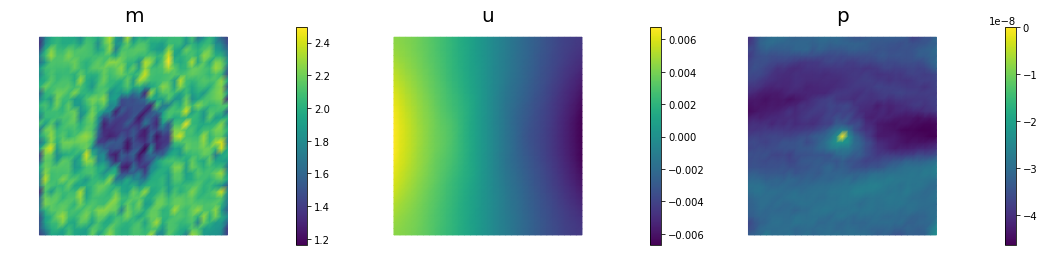

910   1.15695e-09   1.12322e-09   3.37337e+00   4.19548e-09   2.50000e+04     2
920   1.15596e-09   1.12205e-09   3.39021e+00   2.38702e-09   5.00000e+04     1
Steepest descent converged in  922   iterations


In [164]:
# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(grad_misfit + grad_reg)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset m
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")

    iter += 1
    
norm_misfit.append(misfit_new)
norm_reg.append(reg_new)      
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

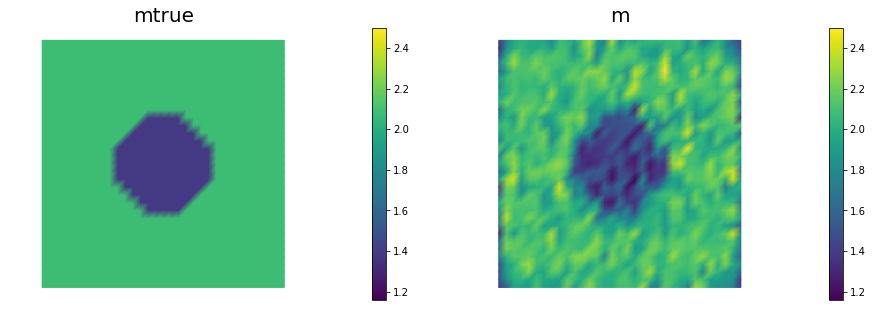

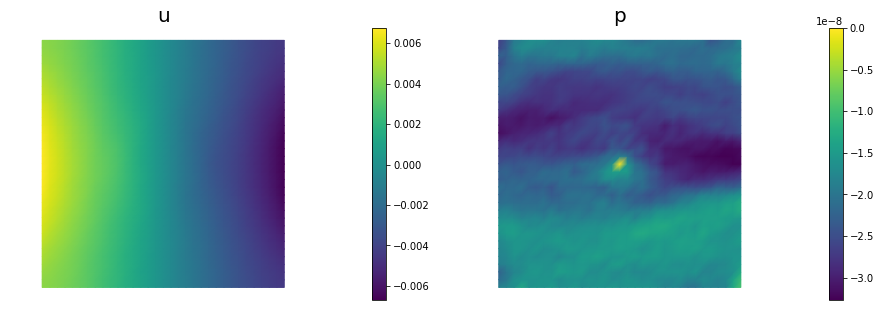

In [165]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

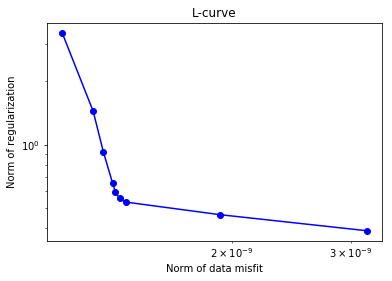

Gamma L-curve 1e-09


In [166]:
# Plot L-curve
plt.loglog(norm_misfit, norm_reg,'-ob')
#plt.loglog(norm_misfit[1], norm_reg[1], 'sr')
plt.title('L-curve')
plt.xlabel('Norm of data misfit')
plt.ylabel('Norm of regularization')
plt.show()

print("Gamma L-curve {0}".format(1e-9) )

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.